# <strong>목차<strong>
1. 신용카드 사용자 연체 데이터 하이퍼 파라미터 튜닝

 1-1. 라이브러리 불러오기

 1-2. 데이터 살펴보기

 1-3. 데이터 전처리

    - 결측치 제거
    - Binary variables
    - Continuous variable
    
        (1) child_num

        (2) inc

        (3) Trpe

    - Minus continuous variable

 1-4. 하이퍼 파라미터 튜닝

    - Gridsearch

    - RandomizedSearchCV

 1-5. 결론


2. 신용카드 데이터 하이퍼 파라미터 튜닝
  
  2-1. 라이브러리 불러오기
  
  2-2. 데이터 전처리

  2-3. 하이퍼 파라미터 튜닝

     - Bayesian

     - Optuna

  2-4. 결론


3. 신용카드 데이터 앙상블 모델
 
 3-1. 라이브러리 불러오기

 3-2. 보팅

    - 하드 보팅

    - 소프트 보팅

 3-3. 스태킹

 3-4. 결론


# **신용카드 사용자 연체 데이터 하이퍼 파라미터 튜닝**

신용카드 사용자 연체 경진대회 링크:  https://dacon.io/competitions/official/235713/data

이번 실습에서는 데이콘에서 진행되었던 "신용카드 사용자 연체" 데이터를 선택하였습니다. EDA 및 전처리를 간단하게 해보고, 하이퍼 파라미터 튜닝에 대해 설명드리겠습니다. 또한, 지난 포스팅에서 진행되었던 신용카드 데이터의 하이퍼 파라미터 튜닝과 앙상블에 대해서 진행해보겠습니다. :)

우선, 하이퍼 파라미터가 궁금하신 분들이 있으실 거예요. 하이퍼 파라미터가 무엇인지 한 번 알아보도록 할게요!!

**하이퍼 파라미터란?**

최적의 훈련 모델을 구현하기 위해 모델에 설정하는 변수로 학습률, 에포크 수, 가중치 초기화 등을 결정할 수 있습니다. 또한 하이퍼 파라미터 튜닝 기법을 적용하여 훈련 모델의 최적값들을 찾을 수 있습니다. 😄

## **라이브러리 불러오기**

In [3]:
! pip install catboost

     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [4]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import itertools

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from tensorflow.keras.utils import to_categorical

In [1]:
from google.colab import drive
drive.mount._DEBUG = True
drive.mount('/content/drive', force_remount=True)

unset HISTFILE; export PS1="root@cac56424fd33-a5f806debd1a4f0a8d63253c128ca064: "
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/content# root@cac56424fd33-a5f806debd1a4f0a8d63253c128ca064: umount -f /content/drive || umount /content/drive; pkill -9 -x drive
umount: /content/drive: no mount point specified.
umount: /content/drive: no mount point specified.
root@cac56424fd33-a5f806debd1a4f0a8d63253c128ca064: pkill -9 -f /opt/google/drive/directoryprefetcher_binary
root@cac56424fd33-a5f806debd1a4f0a8d63253c128ca064: ( while `sleep 0.5`; do if [[ -d "/content/drive" && "$(ls -A /content/drive)" != "" ]]; then echo "google.colab.drive MOUNTED"; break; fi; done ) &
[1] 139
root@cac56424fd33-a5f806debd1a4f0a8d63253c128ca064: ( /opt/google/drive/drive --features=fuse_max_background:1000,max_read_qps:1000,max_write_qps:1000,max_operation_batch_size:15,max_parallel_push_task_instances:10,opendir_timeout_ms:120000,virtual_folders_

In [7]:
import os
os.chdir('/content/drive/MyDrive/DACrew_Team_Zoo/3주차 과제/종합/')

In [ ]:
train=pd.read_csv('./open/train.csv')
test=pd.read_csv('./open/test.csv')
submission=pd.read_csv('./open/sample_submission.csv')

## **데이터 살펴보기**

In [ ]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [ ]:
test.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

## **데이터 전처리**

### **1. 결측치 제거** 

In [ ]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [ ]:
train=train.drop('occyp_type', axis=1)
test=test.drop('occyp_type', axis=1)

### **2. Binary variables**

In [ ]:
train['gender'] = train['gender'].replace(['F','M'],[0,1])
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print('gender :')
print(train['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())
print('--------------')
      
print('Having a phone or not: ')
print(train['phone'].value_counts())
print('--------------')
      

print('Having a email or not: ')
print(train['email'].value_counts())
print('--------------')
      

print('Having a work phone or not: ')
print(train['work_phone'].value_counts())
print('--------------')

gender :
0    17697
1     8760
Name: gender, dtype: int64
--------------
Having a car or not : 
0    16410
1    10047
Name: car, dtype: int64
--------------
Having house reality or not: 
1    17830
0     8627
Name: reality, dtype: int64
--------------
Having a phone or not: 
0    18672
1     7785
Name: phone, dtype: int64
--------------
Having a email or not: 
0    24042
1     2415
Name: email, dtype: int64
--------------
Having a work phone or not: 
0    20511
1     5946
Name: work_phone, dtype: int64
--------------


### **3. Continuous variable**

#### **(1) child_num**

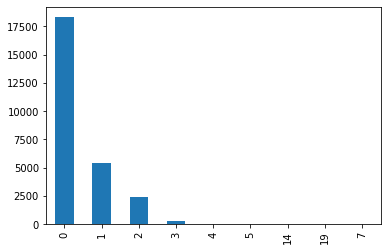

In [ ]:
train['child_num'].value_counts(sort=False).plot.bar()

In [ ]:
train.loc[train['child_num'] >= 2,'child_num']=2
test.loc[test['child_num']>=2, 'child_num']=2

#### **(2) inc**

(2.544, 18.18]      16212
(18.18, 33.66]       8330
(33.66, 49.14]       1530
(49.14, 64.62]        206
(64.62, 80.1]         121
(80.1, 95.58]          44
(95.58, 111.06]         3
(111.06, 126.54]        2
(126.54, 142.02]        4
(142.02, 157.5]         5
Name: income_total, dtype: int64


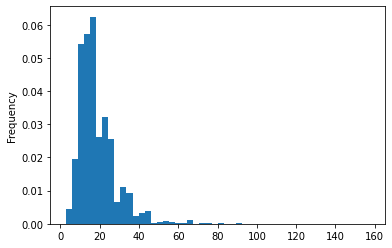

In [ ]:
train['income_total'] = train['income_total'].astype(object)
train['income_total'] = train['income_total']/10000 
test['income_total'] = test['income_total']/10000
##############################################################3
print(train['income_total'].value_counts(bins=10,sort=False))
train['income_total'].plot(kind='hist',bins=50,density=True)

In [ ]:
count, bin_dividers =np.histogram(train['income_total'], bins=7)
bin_names=['소득'+str(i) for i in range(7) ]
#bin_dividers는 train기준!!
train['income_total']=pd.cut(x=train['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)
test['income_total']=pd.cut(x=test['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)


In [ ]:
test

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
0,26457,1,1,0,0,소득0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,2.0,-60.0
1,26458,0,0,1,0,소득0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,2.0,-36.0
2,26459,0,0,1,0,소득0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,2.0,-40.0
3,26460,1,1,0,0,소득0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,2.0,-41.0
4,26461,0,1,1,0,소득0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,2.0,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,0,1,1,0,소득0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,2.0,-19.0
9996,36453,1,1,1,0,소득0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,2.0,-34.0
9997,36454,0,0,1,0,소득1,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,2.0,-55.0
9998,36455,0,1,0,0,소득0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,2.0,-33.0


#### **(3) Type**

In [ ]:
print(train['income_type'].unique())
print(train['edu_type'].unique())
print(train['family_type'].unique())
print(train['house_type'].unique())

['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']
['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']


In [ ]:
test['income_type'].value_counts()

Working                 5174
Commercial associate    2288
Pensioner               1703
State servant            831
Student                    4
Name: income_type, dtype: int64

In [ ]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
train['income_type']=label_encoder.fit_transform(train['income_type'])
test['income_type']=label_encoder.transform(test['income_type'])
########################################################################
train['edu_type']=label_encoder.fit_transform(train['edu_type'])
test['edu_type']=label_encoder.transform(test['edu_type'])
########################################################################
train['family_type']=label_encoder.fit_transform(train['family_type'])
test['family_type']=label_encoder.transform(test['family_type'])
########################################################################
train['house_type']=label_encoder.fit_transform(train['house_type'])
test['house_type']=label_encoder.transform(test['house_type'])
########################################################################
train['income_total']=label_encoder.fit_transform(train['income_total'])
test['income_total']=label_encoder.fit_transform(test['income_total'])

In [ ]:
test['income_type'].value_counts()

4    5174
0    2288
1    1703
2     831
3       4
Name: income_type, dtype: int64

### **4. Minus continuous variable**

In [ ]:
#minus 변경하고
#구간화 함수
def make_bin(variable, n):
    train[variable]=-train[variable]
    test[variable]=-test[variable]
    count, bin_dividers =np.histogram(train[variable], bins=n) #train의 구간화를 적용
    bin_names=[str(i) for i in range(n)]
    train[variable]=pd.cut(x=train[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable]=pd.cut(x=test[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable].fillna(str(0), inplace=True) #test에는 없는 것을 임의의 값으로 채움
    ##########################################################
    train[variable]=label_encoder.fit_transform(train[variable])
    test[variable]=label_encoder.transform(test[variable])

In [ ]:
train.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'family_size', 'begin_month', 'credit'],
      dtype='object')

In [ ]:
make_bin('DAYS_BIRTH', n=10)
make_bin('DAYS_EMPLOYED', n=6)
make_bin('begin_month', n=4)

In [ ]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,0,0,0,1,1,2,3,1,1,0,0,0,2.0,0,1.0
1,1,0,0,1,1,0,0,4,0,1,2,1,1,0,0,1,3.0,0,1.0
2,2,1,1,1,0,1,4,1,1,1,6,1,1,0,1,0,2.0,1,2.0
3,3,0,0,1,0,0,0,4,1,1,4,1,1,0,1,0,2.0,2,0.0
4,4,0,1,1,0,0,2,1,1,1,4,1,1,0,0,0,2.0,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,0,0,0,2,0,2,4,1,1,2,1,1,0,0,0,4.0,0,1.0
26453,26453,0,0,1,1,0,4,1,2,1,4,1,1,0,0,0,2.0,3,2.0
26454,26454,0,1,0,0,1,4,4,0,5,1,1,1,0,0,0,2.0,1,2.0
26455,26455,1,0,1,0,0,4,2,3,1,1,1,1,0,0,0,1.0,3,2.0


In [ ]:
test

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
0,26457,1,1,0,0,0,1,4,0,1,8,0,1,0,1,0,2.0,3
1,26458,0,0,1,0,0,2,1,1,1,6,1,1,0,1,0,2.0,2
2,26459,0,0,1,0,0,4,4,1,1,4,1,1,1,1,0,2.0,2
3,26460,1,1,0,0,0,0,4,1,1,6,1,1,1,0,0,2.0,2
4,26461,0,1,1,0,0,2,1,1,1,5,1,1,1,0,0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,0,1,1,0,0,4,2,1,1,6,1,1,1,1,0,2.0,1
9996,36453,1,1,1,0,0,4,4,0,1,1,1,1,1,0,0,2.0,2
9997,36454,0,0,1,0,1,4,4,1,1,7,1,1,0,0,0,2.0,3
9998,36455,0,1,0,0,0,0,4,1,1,5,1,1,0,1,0,2.0,2


In [ ]:
train.shape

(26457, 19)

In [ ]:
test.shape

(10000, 18)

## **하이퍼 파라미터 튜닝**

In [ ]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test

### **Gridsearch**

Grid Search는 탐색의 대상이 되는 특정 구간 내의 후보 하이퍼 파라미터 값들을 일정한 간격을 두고 선정합니다.

- 후보 값들에 대하여 성능 결과를 기록한 뒤, 가장 높은 성능을 발휘했던 하이퍼파라미터 값을 선정합니다. 즉, 모든 경우의 수에 대해 cross-validation 결과가 가장 좋은 파라미터를 고르는 방법입니다.

- 전체 탐색 대상 구간을 어떻게 설정할지, 간격은 어떻게 설정할지 등을 결정하는 것은 여전히 사람의 개입이 필요한 과정입니다.

그럼 Gridsearch 방법에 대해서 단계별로 진행해보겠습니다. 이번에는 LightGBM 모델로 최적의 하이퍼 파라미터를 찾아보겠습니다.😃

In [ ]:
# LGBMClassifier의 하이퍼 파라미터 default 상태
model = LGBMClassifier()
model

LGBMClassifier()

1) 모델을 먼저 생성합니다.

In [ ]:
LGB=LGBMClassifier(boosting_type='gbdt',  objective='multiclass')
LGB

LGBMClassifier(objective='multiclass')

2) 원하는 파라미터를 dict 형태로 만들어 놓습니다.

In [ ]:
param_grid = {
    'max_depth': [6, 8, 10],
    'learnig_rate': [0.005, 0.01, 0.1]
    }

3) kfold를 설정해줍니다

In [ ]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=55)

4) 1~3에서 지정한 정보를 바탕으로 GriedSearchCV 함수 안에 포함합니다.

In [ ]:
gcv=GridSearchCV(LGB, param_grid=param_grid, cv=folds,  n_jobs=-1)

5) 만들어진 모델로 fit을 하고, 최적의 파라미터를 찾아줍니다.

In [ ]:
gcv.fit(train_x, train_y)
print('final params', gcv.best_params_)   # 최적의 파라미터 값 출력

final params {'learnig_rate': 0.005, 'max_depth': 8}


6) GridSearch로 찾은 best 파라미터를 활용해서 다시 학습을 진행합니다.

In [ ]:
LGB_CV=LGBMClassifier(boosting_type='gbdt',  objective='multiclass', max_depth=gcv.best_params_['max_depth'], learning_rate=gcv.best_params_['learnig_rate'])
LGB_CV

In [ ]:
def run_kfold(model):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        print(f'===================================={n_fold+1}============================================')

        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        
        model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)], 
            early_stopping_rounds=30,
            verbose=100)
        
        predictions=model.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=model.predict_proba(test_x)
        
        print(f'================================================================================\n\n')
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

7) Gridsearch 튜닝 모델

In [ ]:
my_submission = run_kfold(LGB_CV)

====================================1============================================
Training until validation scores don't improve for 30 rounds.
[100]	training's multi_logloss: 0.865069	valid_1's multi_logloss: 0.871325
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.865069	valid_1's multi_logloss: 0.871325
FOLD 0 : logloss:0.8713250863849558


====================================2============================================
Training until validation scores don't improve for 30 rounds.
[100]	training's multi_logloss: 0.865308	valid_1's multi_logloss: 0.870303
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.865308	valid_1's multi_logloss: 0.870303
FOLD 1 : logloss:0.8703026219130882


====================================3============================================
Training until validation scores don't improve for 30 rounds.
[100]	training's multi_logloss: 0.8649	valid_1's multi_logloss: 0.871109
Did not meet early stop

### **RandomizedSearchCV**

greadsearch 방법과 거의 동일한 방법입니다. 탐색 대상 구간 내의 후보 하이퍼 파라미터 값들을 랜덤 샘플링을 통해 선정합니다.

- Grid Search에 비해 불필요한 반복 수행 횟수를 대폭 줄이면서, 동시에 정해진 간격(grid) 사이에 위치한 값들에 대해서도 확률적으로 탐색합니다.

- 모든 grid를 전부 탐색하는 대신, 랜덤하게 일부의 파라미터들만 관측한 후, 그 중에서 가장 좋은 파라미터를 채택하게 됩니다.


Gridsearch 방법과 마찬가지로 RandomizedSearchCV에 대해서 알아보도록 하겠습니다. :)

In [ ]:
# LGBMClassifier의 하이퍼 파라미터 default 상태
model = LGBMClassifier()
model

LGBMClassifier()

1) 모델을 생성합니다.

In [ ]:
LGB=LGBMClassifier(boosting_type='gbdt',  objective='multiclass')
LGB

LGBMClassifier(objective='multiclass')

2) 원하는 파라미터를 dict 형태로 만들어 놓습니다.

In [ ]:
param_grid = {
    'max_depth': [6, 8, 10],
    'learnig_rate': [0.005, 0.01, 0.1]
    }

3) kfold를 지정합니다.

In [ ]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=55)

4) 1~3에서 지정한 정보를 바탕으로 RandomizedSearchCV 함수 안에 포함합니다.  
- 유의하실 점은 param_distributions=param_grid 이부분의 파라미터가 gridsearch와 다릅니다.

In [ ]:
gcv=RandomizedSearchCV(LGB, param_distributions=param_grid, cv=folds,  n_jobs=-1)

5) 만들어진 모델로 fit을 하고, 최적의 파라미터를 찾아줍니다.

In [ ]:
gcv.fit(train_x, train_y)
print('final params', gcv.best_params_)   # 최적의 파라미터 값 출력

final params {'max_depth': 8, 'learnig_rate': 0.005}


6) RandomizedSearchCV 로 찾은 best 파라미터를 활용해서 다시 학습을 진행합니다.

In [ ]:
LGB_CV=LGBMClassifier(boosting_type='gbdt',  objective='multiclass', max_depth=gcv.best_params_['max_depth'], learning_rate=gcv.best_params_['learnig_rate'])
LGB_CV

LGBMClassifier(learning_rate=0.005, max_depth=8, objective='multiclass')

In [ ]:
def run_kfold(model):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        print(f'===================================={n_fold+1}============================================')

        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        
        model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)], 
            early_stopping_rounds=30,
            verbose=100)
        
        predictions=model.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=model.predict_proba(test_x)
        
        print(f'================================================================================\n\n')
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

7) RandomizedSearchCV 튜닝 모델



In [ ]:
my_submission = run_kfold(LGB_CV)

====================================1============================================
Training until validation scores don't improve for 30 rounds.
[100]	training's multi_logloss: 0.865069	valid_1's multi_logloss: 0.871325
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.865069	valid_1's multi_logloss: 0.871325
FOLD 0 : logloss:0.8713250863849558


====================================2============================================
Training until validation scores don't improve for 30 rounds.
[100]	training's multi_logloss: 0.865308	valid_1's multi_logloss: 0.870303
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.865308	valid_1's multi_logloss: 0.870303
FOLD 1 : logloss:0.8703026219130882


====================================3============================================
Training until validation scores don't improve for 30 rounds.
[100]	training's multi_logloss: 0.8649	valid_1's multi_logloss: 0.871109
Did not meet early stop

## **결론**

결론적으로 Gridsearch와 RandomizedSearchCV 방법으로 하이퍼 파라미터를 탐색했을 때, 같은 값을 선정하는 것을 볼 수 있었습니다. (max_depth = 8, learnig_rate = 0.005)

하지만 어떤 하이퍼 파라미터의 값들을 정의해주는 경우에 따라서 최적의 하이퍼 파라미터 값은 달라질 수 있으니, 이 점 유의하시면 좋을 것 같습니다!

# **신용카드 데이터 하이퍼 파라미터 튜닝**
- 전처리와 EDA에 대한 전체적인 과정은 이전 포스팅에 작성된 글로 본 글에서는 생략하였습니다. 궁금하신 분들은 이전 포스팅을 참고하시고 다음 실습을 진행하시는 것을 권장드립니다 :)

## **라이브러리 불러오기**

In [5]:
import os
import matplotlib as mpl
%matplotlib inline

from sklearn import preprocessing as pp 
from scipy.stats import pearsonr
import xgboost as xgb
import lightgbm as lgb

In [8]:
data = pd.read_csv('./open/credit_card.csv')

## **데이터 전처리**

In [9]:
# 피쳐 행렬 및 레이블 배열 생성하기
dataX = data.copy().drop(['Class'],axis=1)
dataY = data['Class'].copy()

In [10]:
# 피쳐 스케일링
featuresToScale = dataX.drop(['Time'],axis=1).columns

In [11]:
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
scalingFactors = pd.DataFrame(data=[sX.mean_,sX.scale_],index=['Mean','StDev'],columns=featuresToScale)

## **하이퍼 파라미터 튜닝**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(dataX, 
                                    dataY, test_size=0.33, 
                                    random_state=2018, stratify=dataY)

In [13]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)

#### **Bayesian**

베이지안 방법은 목적함수를 최대 또는 최소로 하는 최적해를 찾는 방법입니다.

- 목적함수와 하이퍼 파라미터의 조합을 대상으로 Surrogate model을 만들어 평가하고 Acquisition Function이 다음 인풋으로 사용할 조합을 추천하는 과정을 반복하면서 순차적으로 업데이트하여 최적의 조합을 찾아냅니다.

- 즉, 목적 함수(탐색대상 함수)와 하이퍼 파라미터 쌍을 대상으로 Surrogate Model(대체 모델) 을 만들고 순차적으로 하이퍼 파라미터를 업데이트해 가면서 평가를 통해 최적의 하이퍼 파라미터 조합을 탐색합니다.

✔ 여기서 잠깐❗❗ ✔

**Surrogate Model이란?**

목적 함수에 대한 확률적으로 추정하는 모델입니다. 현재까지 조사된 입력값-함수 결과 값 점들 ($x_1,f(x_1)$),...,($x_t,f(x_t)$) 을 바탕으로, 미지의 목적 함수의 형태에 대한 확률적인 추정을 수행하는 모델입니다.

**Acquisition function이란?**

Surrogate Model이 확률적으로 추정한 결과를 바탕으로 '최적 입력값을 찾는 데 있어 가장 유용할 만한' 다음 입력값 후보를 추천해 주는 함수입니다.

그럼 베이지안 방법에 대해서 실습을 진행해볼게요. 😊

In [19]:
import warnings
warnings.filterwarnings('ignore')
def XGB_cv(learning_rate
           ,min_child_weight, subsample
           ,colsample_bytree, silent=True, nthread=-1) :
    trainingScores = []
    cvScores = []
    predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                        index=y_train.index,columns=['prediction'])

    for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),
                                              y_train.ravel()):
        X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
            X_train.iloc[cv_index,:]
        y_train_fold, y_cv_fold = y_train.iloc[train_index], \
            y_train.iloc[cv_index]

        dtrain = xgb.DMatrix(data=X_train_fold, label=y_train_fold)
        dCV = xgb.DMatrix(data=X_cv_fold)
        # 하이퍼 파라미터 설정
        params={'max_depth':6,
              'learning_rate':learning_rate,
              'nthread':nthread,
              'gamma':5,
              'min_child_weight':min_child_weight,
              'max_delta_step':0,
              'subsample':subsample,
              'colsample_bytree':colsample_bytree,
              'objective':'binary:logistic',
              'eval_metric':'logloss',
              'seed' : 2018}
        bst = xgb.cv(params, dtrain, num_boost_round=2000, 
                     nfold=5, early_stopping_rounds=200, verbose_eval=50)

        best_rounds = np.argmin(np.array(bst['test-logloss-mean']))
        bst = xgb.train(params, dtrain, best_rounds)

        loglossTraining = log_loss(y_train_fold, bst.predict(dtrain))
        trainingScores.append(loglossTraining)

        predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
            bst.predict(dCV)
        loglossCV = log_loss(y_cv_fold, \
            predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
        cvScores.append(loglossCV)

        print('Training Log Loss: ', loglossTraining)
        print('CV Log Loss: ', loglossCV)

    loglossXGBoostGradientBoosting = \
        log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
    print('XGBoost Gradient Boosting Log Loss: ', loglossXGBoostGradientBoosting)

    #예측값 출력
    predictionsTestSetXGBoostGradientBoosting = \
    pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
    dtest = xgb.DMatrix(data=X_test)
    predictionsTestSetXGBoostGradientBoosting.loc[:,'prediction'] = \
        bst.predict(dtest)
    
    # 성능 지표 출력
    logLossTestSetXGBoostGradientBoosting = \
        log_loss(y_test, predictionsTestSetXGBoostGradientBoosting)
    return -loglossXGBoostGradientBoosting

In [15]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=8300cc4920f456349f46ebd26ca86424fe5c835bc4588b829ab75c7693bdd309
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [20]:
from bayes_opt import BayesianOptimization
import numpy as np
pbounds_xGB = {
    'learning_rate': (0.01,0.3), # 학습률 : 범위 (0 ~ 1) , 디폴트 0.3
    'min_child_weight': (0,3), # min_child_weight : 범위 (0 ~ 무한대) , 디폴트 1 ## 자식노드에 필요한 가중치의 최소 합계
    'subsample':(0.5,1.0), # subsample : 범위 (0 ~ 1) , 디폴트 1
        # 훈련 데이터의 샘플링 비율
    'colsample_bytree': (0.5,1.0), # colsample_bytree : 범위 (0 ~ 1) , 디폴트 1
        # 훈련 피쳐의 샘플링 비율
 }

bo=BayesianOptimization(f=XGB_cv, pbounds=pbounds_xGB, verbose=2, random_state=2022)   

In [ ]:
# init_points :  초기 Random Search 개수
# n_iter : 반복 횟수 (몇개의 입력값-함숫값 점들을 확인할지! 많을 수록 정확한 값을 얻을 수 있음)
# acq : Acquisition Function들 중 Expected Improvement(EI) 를 사용
# xi : exploration 강도 (기본값은 0.0)
bo.maximize(init_points=2, n_iter=10, acq='ei', xi=0.01)

|   iter    |  target   | colsam... | learni... | min_ch... | subsample |
-------------------------------------------------------------------------
[0]	train-logloss:0.550931+1.5028e-05	test-logloss:0.550937+5.63028e-05
[50]	train-logloss:0.0021134+7.66619e-05	test-logloss:0.0030986+0.000283799
[100]	train-logloss:0.0012428+6.33606e-05	test-logloss:0.0030046+0.000309173
[150]	train-logloss:0.001043+3.71106e-05	test-logloss:0.0030084+0.000338185
[200]	train-logloss:0.0009536+3.00839e-05	test-logloss:0.0030072+0.000349153
[250]	train-logloss:0.0009002+3.42602e-05	test-logloss:0.0030108+0.000349419
Training Log Loss:  0.001611136422197388
CV Log Loss:  0.002553896360378446
[0]	train-logloss:0.550901+2.31344e-05	test-logloss:0.550911+4.31768e-05
[50]	train-logloss:0.002035+8.53299e-05	test-logloss:0.002971+0.000378578
[100]	train-logloss:0.0011812+7.35511e-05	test-logloss:0.0028708+0.000412644
[150]	train-logloss:0.0009926+4.85576e-05	test-logloss:0.0028874+0.000431057
[200]	train-logloss:

In [ ]:
print(bo.max)

#### **Optuna**

하이퍼 파라미터 최적화 테스크를 자동화해주는 프레임워크입니다.

- 목적 함수에 기반한 최적화 과정입니다. 여러 번의 시행을 거쳐 최적의 하이퍼 파라미터 조합을 찾는 것이 목적입니다.

- 거의 모든 ML/DL 프레임워크에서 사용 가능한 넓은 범용성을 가지고 있습니다.

- 최신 동향의 다양한 최적화 알고리즘을 갖추고 있고, 병렬처리가 가능합니다.

optuna에 대해 간단하게 이론에 대해서 알아보았으니, 실습을 진행해 볼게요. :)

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 6.3 MB/s 
     |████████████████████████████████| 210 kB 41.7 MB/s 
     |████████████████████████████████| 81 kB 4.0 MB/s 
     |████████████████████████████████| 78 kB 6.1 MB/s 
     |████████████████████████████████| 146 kB 11.2 MB/s 
     |████████████████████████████████| 113 kB 45.9 MB/s 
     |████████████████████████████████| 49 kB 6.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=ca51510177bf71b1a8f10df73dcdf61d6eebcdfc5c3f3a7c8fbdd6c171cec414
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.metrics import mean_absolute_error

In [ ]:
import warnings
warnings.filterwarnings('ignore')
def XGB_cv(trial) :
    trainingScores = []
    cvScores = []
    predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                        index=y_train.index,columns=['prediction'])

    for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),
                                              y_train.ravel()):
        X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
            X_train.iloc[cv_index,:]
        y_train_fold, y_cv_fold = y_train.iloc[train_index], \
            y_train.iloc[cv_index]

        dtrain = xgb.DMatrix(data=X_train_fold, label=y_train_fold)
        dCV = xgb.DMatrix(data=X_cv_fold)
        param_xgb = {
                    'nthread':16, # 코어 수
                    'n_estimators' : trial.suggest_int('n_estimators', 100, 500),
                    'learning_rate': trial.suggest_loguniform('learning_rate',0.01,0.3), # 학습률 : 범위 (0 ~ 1) , 디폴트 0.3
                    'gamma': trial.suggest_int('gamma',0,100), # 감마 : 범위 (0 ~ 무한대) , 디폴트 0
                        # 이 값이 높으면 복잡성이 감소(편향 증가, 변동 감소) 
                    'max_depth' : trial.suggest_int('max_depth', 4, 8), # max_depth : 범위 (1 ~ 무한대) , 디폴트 6 ## 트리의 최대 깊이
                    'min_child_weight': trial.suggest_int('min_child_weight',0,3), # min_child_weight : 범위 (0 ~ 무한대) , 디폴트 1 ## 자식노드에 필요한 가중치의 최소 합계
                    'max_delta_step': 0, # max_delta_step : 범위 (0 ~ 무한대) ,  디폴트 0 ## 각 트리의 가중치 추정을 위한 최대 델타 단계
                    'subsample':trial.suggest_categorical('subsample',[0.5,1]), # subsample : 범위 (0 ~ 1) , 디폴트 1
                        # 훈련 데이터의 샘플링 비율
                    'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree',0.5,1.0,0.1), # colsample_bytree : 범위 (0 ~ 1) , 디폴트 1
                        # 훈련 피쳐의 샘플링 비율
                    'objective':'binary:logistic',
                    'num_class':1,
                    'eval_metric':'logloss',
                    'seed':2018
                }
        bst = xgb.cv(param_xgb, dtrain, num_boost_round=2000, 
                     nfold=5, early_stopping_rounds=200, verbose_eval=50)

        best_rounds = np.argmin(np.array(bst['test-logloss-mean']))
        bst = xgb.train(param_xgb, dtrain, best_rounds)

        loglossTraining = log_loss(y_train_fold, bst.predict(dtrain))
        trainingScores.append(loglossTraining)

        predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
            bst.predict(dCV)
        loglossCV = log_loss(y_cv_fold, \
            predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
        cvScores.append(loglossCV)

        print('Training Log Loss: ', loglossTraining)
        print('CV Log Loss: ', loglossCV)

    loglossXGBoostGradientBoosting = \
        log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
    print('XGBoost Gradient Boosting Log Loss: ', loglossXGBoostGradientBoosting)
    
    # 예측값 출력
    predictionsTestSetXGBoostGradientBoosting = \
    pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
    dtest = xgb.DMatrix(data=X_test)
    predictionsTestSetXGBoostGradientBoosting.loc[:,'prediction'] = \
        bst.predict(dtest)
    
    #평가 지표
    logLossTestSetXGBoostGradientBoosting = \
        log_loss(y_test, predictionsTestSetXGBoostGradientBoosting)
    return -loglossXGBoostGradientBoosting

In [ ]:
study = optuna.create_study(direction='maximize')
# trail : 반복 시행 횟수
study.optimize(XGB_cv, n_trials=10)

[I 2022-04-20 10:11:22,919] A new study created in memory with name: no-name-ee7133e3-bfb9-45f9-8ff2-040cc05a5cf6


[0]	train-logloss:0.664914+1.72047e-06	test-logloss:0.664896+3.81576e-06
[50]	train-logloss:0.12326+4.61216e-05	test-logloss:0.123343+7.07231e-05
[100]	train-logloss:0.0299454+5.90173e-05	test-logloss:0.0300766+0.000153165
[150]	train-logloss:0.0093406+4.8607e-05	test-logloss:0.0094936+0.000258946
[200]	train-logloss:0.0046488+7.9058e-05	test-logloss:0.0048406+0.000299794
[250]	train-logloss:0.0035996+8.27734e-05	test-logloss:0.0038272+0.000329754
[300]	train-logloss:0.0033572+7.63057e-05	test-logloss:0.0036126+0.000348719
[350]	train-logloss:0.0032834+7.48535e-05	test-logloss:0.0035504+0.000356185
[400]	train-logloss:0.0032222+6.98324e-05	test-logloss:0.0035058+0.000356362
[450]	train-logloss:0.0031902+6.72113e-05	test-logloss:0.0034844+0.000362366
[500]	train-logloss:0.0031756+6.95805e-05	test-logloss:0.0034718+0.000361946
[550]	train-logloss:0.003165+6.89551e-05	test-logloss:0.0034606+0.000362688
[600]	train-logloss:0.0031562+6.95799e-05	test-logloss:0.0034586+0.000362307
[650]	trai

[I 2022-04-20 14:04:34,073] Trial 0 finished with value: -0.0031751538956069658 and parameters: {'n_estimators': 497, 'learning_rate': 0.02877213468447734, 'gamma': 25, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial 0 with value: -0.0031751538956069658.


[0]	train-logloss:0.61812+9.06863e-06	test-logloss:0.618108+1.87339e-05
[50]	train-logloss:0.0117344+4.08245e-05	test-logloss:0.0118936+0.000210785
[100]	train-logloss:0.0033866+4.25939e-05	test-logloss:0.0036238+0.000323524
[150]	train-logloss:0.003178+7.69493e-05	test-logloss:0.003472+0.00034152
[200]	train-logloss:0.003118+7.38404e-05	test-logloss:0.0034316+0.000342709
[250]	train-logloss:0.0031144+6.87506e-05	test-logloss:0.0034294+0.000350482
[300]	train-logloss:0.0030994+6.52674e-05	test-logloss:0.0034124+0.000348086
[350]	train-logloss:0.0030646+5.9227e-05	test-logloss:0.0033826+0.00034094
[400]	train-logloss:0.0030592+6.23583e-05	test-logloss:0.0033788+0.000344237
[450]	train-logloss:0.003059+6.24404e-05	test-logloss:0.0033776+0.000343186
[500]	train-logloss:0.0030434+7.23646e-05	test-logloss:0.0033652+0.000335311
[550]	train-logloss:0.0030376+6.44813e-05	test-logloss:0.0033604+0.000342832
[600]	train-logloss:0.0030158+4.02711e-05	test-logloss:0.00334+0.000341476
[650]	train-lo

[I 2022-04-20 16:57:54,909] Trial 1 finished with value: -0.003141419157625227 and parameters: {'n_estimators': 230, 'learning_rate': 0.07836110781797968, 'gamma': 24, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial 1 with value: -0.003141419157625227.


[0]	train-logloss:0.65242+9.02441e-06	test-logloss:0.652406+2.60691e-05
[50]	train-logloss:0.0625264+5.52217e-05	test-logloss:0.0626536+0.000106455
[100]	train-logloss:0.010063+7.72994e-05	test-logloss:0.0102348+0.000218063
[150]	train-logloss:0.0039702+7.15665e-05	test-logloss:0.0041854+0.000288091
[200]	train-logloss:0.0034148+7.38767e-05	test-logloss:0.0036564+0.000315043
[250]	train-logloss:0.0033774+7.6445e-05	test-logloss:0.0036292+0.00031946
[300]	train-logloss:0.00337+8.20658e-05	test-logloss:0.0036264+0.000317883
[350]	train-logloss:0.0033624+8.69496e-05	test-logloss:0.0036254+0.000317441
[400]	train-logloss:0.0033624+8.69496e-05	test-logloss:0.0036254+0.000317441
[450]	train-logloss:0.0033626+8.67793e-05	test-logloss:0.0036254+0.000317441
[500]	train-logloss:0.0033626+8.67793e-05	test-logloss:0.0036254+0.000317441
[550]	train-logloss:0.0033626+8.67793e-05	test-logloss:0.0036254+0.000317441
[600]	train-logloss:0.0033626+8.67793e-05	test-logloss:0.0036254+0.000317441
Training L

[I 2022-04-20 18:10:16,654] Trial 2 finished with value: -0.0034327571996961084 and parameters: {'n_estimators': 197, 'learning_rate': 0.04174793947893187, 'gamma': 35, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 1, 'colsample_bytree': 0.9}. Best is trial 1 with value: -0.003141419157625227.


[0]	train-logloss:0.6823+8.94427e-07	test-logloss:0.682286+2.31517e-06


In [ ]:
print(study.best_trial.params)

In [ ]:
optuna_acc = study.best_trial.value
print(optuna_acc)

In [ ]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study)

# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study)


## **결론**

여기까지 Gridsearch, RandomizedSearchCV, Bayesian, Optuna등 다양한 하이퍼파라미터 튜닝 방법에 대해 알아보았습니다. 다양한 튜닝 방법이 있지만 경험적으로 범위를 잘 설정해주는 것이 중요할 것 같습니다. 데이터와 목적에 맞게 잘 설정을 해서 활용한다면 아주 유용한 방법입니다. 여러분들도 앞으로 이러한 튜닝 방법을 잘 활용해보고, 도움이 많이 되셨으면 좋겠습니다~!

# **신용카드 데이터 앙상블 모델**

## **라이브러리 불러오기**

In [18]:
'''시간 측정용 라이브러리'''
import time

'''데이터 준비 관련 라이브러리'''
from sklearn.metrics import log_loss

'''알고리즘 관련 라이브러리'''
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.33, random_state=42, stratify=dataY)

## **보팅**
보팅 앙상블은 같은 데이터에 여러 개의 모델을 사용하여 예측된 결과값을 집계하여 최종 예측 값을 투표하는 방식입니다.

보팅 앙상블에는 hard voting, soft voting 두가지 방식이 있습니다.

여기서는 이전에 사용했던 3개의 모델(Decision Tree, Random Forest, LightGBM)을 사용해서 두가지 voting을 진행해보겠습니다

### **하드 보팅**

- 다수의 분류기가 예측한 결과값을 최종 결과값으로 선정하는 방법입니다.

<image src='https://drive.google.com/uc?id=1YSNzazN3Ew7mh3zQVNCsk5mBpcYA7E0b'
 height=270 width=550>

In [ ]:
#Decision Tree 모델 생성
model_tree = DecisionTreeClassifier(random_state = 42)

#Random Forest 모델 생성
model_forest = RandomForestClassifier(random_state = 42, n_jobs = -1)

#Light Gradient Boosting 모델 생성
model_lgbm = LGBMClassifier(random_state = 42, 
                            learning_rate = 0.005, 
                            max_depth = 10, 
                            num_leaves = 31, 
                            n_estimators = 3000)

#hard voting 모델 생성
model_hard_vote = VotingClassifier(estimators=[('tree', model_tree), ('forest', model_forest), ('lgbm', model_lgbm)], voting = 'hard', n_jobs = -1)

#Test 데이터 학습
model_hard_vote = model_hard_vote.fit(X_train, y_train)

#X_test 데이터를 사용해 y_test 타겟 레이블 예측
hard_vote_pred = model_hard_vote.predict(X_test)

#모델의 예측 성능을 log_loss를 이용하여 출력
print("3개 모델 hard voting 모델 손실 값: %.4f" %log_loss(y_test, hard_vote_pred))

3개 모델 hard voting 모델 손실 값: 0.0147


### **소프트 보팅**

- 모든 분류기가 예측한 확률 평균을 구한 뒤 확률이 높은 값을 최종 결과값으로 선정하는 방법입니다.

<image src='https://drive.google.com/uc?id=1R5EYHMoyJkEE2GgkEhnD4886q9bxpLIb'
 height=300 width=850>

In [ ]:
#Decision Tree 모델 생성
model_tree = DecisionTreeClassifier(random_state = 42)

#Random Forest 모델 생성
model_forest = RandomForestClassifier(random_state = 42, n_jobs = -1)

#Light Gradient Boosting 모델 생성
model_lgbm = LGBMClassifier(random_state = 42, 
                            learning_rate = 0.005, 
                            max_depth = 10, 
                            num_leaves = 31, 
                            n_estimators = 3000)

#soft voting 모델 생성
model_soft_vote = VotingClassifier(estimators=[('tree', model_tree), ('forest', model_forest), ('lgbm', model_lgbm)], voting = 'soft', n_jobs = -1)

#Test 데이터 학습
model_soft_vote = model_soft_vote.fit(X_train, y_train)

#X_test 데이터를 사용해 y_test 타겟 레이블 예측
soft_vote_pred = model_soft_vote.predict(X_test)

#모델의 예측 성능을 log_loss를 이용하여 출력
print("3개 모델 soft voting 모델 손실 값: %.4f" %log_loss(y_test, soft_vote_pred))

3개 모델 soft voting 모델 손실 값: 0.0147


hard/soft voting 적용 결과, 모델의 손실 값이 0.0147로 같은 것을 알 수 있었습니다.

## **스태킹**
스태킹은 개별 모델이 예측한 데이터를 다시 meta dataset으로 사용하여 최종 모델 meta learner에서 학습하는 방식입니다.

<image src='https://drive.google.com/uc?id=1g7K-obwByAu0nCZhUfbxDjMf_Y5a1KUu'
 height=250 width=500>

여기서는 이전에 사용했던 3개의 모델(Decision Tree, Random Forest, LightGBM)에서 예측한 데이터을 사용하고, meta learner으로는 logistic regression을 사용해서 학습을 진행해보도록 하겠습니다.

- **DecisionTree**

In [ ]:
#수행 시간 측정을 위한 시작 시간 측정
start_time = time.time()

#Decision Tree 모델 생성
model_tree = DecisionTreeClassifier(random_state = 42)

#Test 데이터 학습
model_tree = model_tree.fit(X_train, y_train)

#X_test 데이터를 사용해 y_test 타겟 레이블 예측
tree_pred = model_tree.predict(X_test)

#모델의 예측 성능을 log_loss를 이용하여 출력
print("dicision tree 모델 손실 값: %.4f" %log_loss(y_test, tree_pred))

#수행 시간 출력
print("dicision tree 모델 수행 시간: %.1f 초" %(time.time()-start_time))

dicision tree 모델 손실 값: 0.0290
dicision tree 모델 수행 시간: 17.3 초


- **RandomForest**

In [ ]:
#수행 시간 측정을 위한 시작 시간 측정
start_time = time.time()

#Random Forest 모델 생성
model_forest = RandomForestClassifier(random_state = 42, n_jobs = -1)

#Test 데이터 학습
model_forest = model_forest.fit(X_train, y_train)

#X_test 데이터를 사용해 y_test 타겟 레이블 예측
forest_pred = model_forest.predict(X_test)

#모델의 예측 성능을 log_loss를 이용하여 출력
print("random forest 모델 손실 값: %.4f" %log_loss(y_test, forest_pred))

#수행 시간 출력
print("random forest 모델 수행 시간: %.1f 초" %(time.time()-start_time))

random forest 모델 손실 값: 0.0154
random forest 모델 수행 시간: 125.0 초


- **LightGBM**

In [ ]:
#수행 시간 측정을 위한 시작 시간 측정
start_time = time.time()

#Light Gradient Boosting 모델 생성
model_lgbm = LGBMClassifier(random_state = 42)

#Test 데이터 학습
model_lgbm = model_lgbm.fit(X_train, y_train)

#X_test 데이터를 사용해 y_test 타겟 레이블 예측
lgbm_pred = model_lgbm.predict(X_test)

#모델의 예측 성능을 log_loss를 이용하여 출력
print("light gradient boosting 모델 손실 값: %.4f" %log_loss(y_test, lgbm_pred))

#수행 시간 출력
print("light gradient boosting 모델 수행 시간: %.1f 초" %(time.time()-start_time))

light gradient boosting 모델 손실 값: 0.1003
light gradient boosting 모델 수행 시간: 4.6 초


In [ ]:
#기반 모델의 예측 결과를 스태킹
stacked_pred = np.array([tree_pred, forest_pred, lgbm_pred])

#transepose를 이용하여 행과 열의 위치를 교환하고, 각 모델의 예측 결과를 feature로 사용
stacked_pred = np.transpose(stacked_pred)

#메타 모델로 사용할 logistic regression 모델 생성
model_lr = LogisticRegression(random_state = 42)

#메타 모델은 기반모델의 예측결과를 기반으로 학습
model_lr.fit(stacked_pred, y_test)

#X_test 데이터를 사용해 y_test 타겟 레이블 예측
stack_pred = model_lr.predict(stacked_pred)

#모델의 예측 성능을 log_loss를 이용하여 출력
print("3개 모델 stacking 모델 손실 값: %.4f" %log_loss(y_test, stack_pred))

3개 모델 stacking 모델 손실 값: 0.0184


위의 스태킹 모델에 사용된 메타 모델은 결국 y_test(테스트 데이터)를 학습했기 때문에 과적합 문제가 발생할 수 있습니다. 따라서 CV 세트 기반의 스태킹 모델을 구현해서 사용하는것을 권장합니다.

## **결론**

In [ ]:
print("dicision tree 모델 손실 값: %.4f" %log_loss(y_test, tree_pred))
print("random forest 모델 손실 값: %.4f" %log_loss(y_test, forest_pred))
print("light gradient boosting 모델 손실 값: %.4f" %log_loss(y_test, lgbm_pred))
print("3개 모델 hard voting 모델 손실 값: %.4f" %log_loss(y_test, hard_vote_pred))
print("3개 모델 soft voting 모델 손실 값: %.4f" %log_loss(y_test, soft_vote_pred))
print("3개 모델 stacking 모델 손실 값: %.4f" %log_loss(y_test, stack_pred))

dicision tree 모델 손실 값: 0.0290
random forest 모델 손실 값: 0.0154
light gradient boosting 모델 손실 값: 0.1003
3개 모델 hard voting 모델 손실 값: 0.0147
3개 모델 soft voting 모델 손실 값: 0.0147
3개 모델 stacking 모델 손실 값: 0.0184


여러 모델에 대해서 비교해 본 결과, 단일 모델을 비교했을 때는 Random Forest 모델의 성능이 더 좋은 것을 확인하였습니다. 또한 보팅과 스태킹의 경우, 하드 보팅과 소프트 보팅은 0.0147로 개선된 한편, 스태킹 모델에서는 0.0184로 Random Forest와 LightGBM 모델보다 성능이 떨어진 것을 알 수 있었습니다.

하지만 이 과정도 사용자들의 판단에 따라서 모델의 성능 척도가 달라질 수 있으므로 다양한 방법을 거치는 과정이 중요하다고 생각합니다.

지금까지
- Gridsearch
- RandomizedSearch
- Bayesian
- Optuna
- voting: soft voting, hard voting
- stacking

하이퍼 파라미터와 앙상블 학습법에 대해서 살펴보았습니다. 😃


2~3주차에서는 지도 학습에 대해서 배워봤는데요. 그럼 비지도 학습에 대해서도 알아봐야겠죠?

다음 포스팅에서는 비지도 학습에 대해서 진행해볼게요!! 많이 기대해주세요. :)